In [1]:
import inspect
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection

import pymc3 as pm
from pymc3 import sampling_jax

import theano.tensor as tt
import arviz as az

# %matplotlib

/Users/ajl573/.virtualenvs/base/lib/python3.8/site-packages/pymc3/sampling_jax.py:24: UserWarning: This module is experimental.
  warnings.warn("This module is experimental.")


In [4]:
track = pd.read_csv('../examples/data/modes.csv')
track.head()

frac_age  delta_nu_fit      nu_max  nu_0_1     nu_0_2     nu_0_3  \
0  0.000016     11.884045  150.680452     0.0  34.481794  49.329712   
1  0.000017     12.140476  154.893200     0.0  35.203007  50.376320   
2  0.000017     12.343045  158.238356     0.0  35.772049  51.202159   
3  0.000018     12.503403  160.898485     0.0  36.222266  51.855582   
4  0.000018     12.633487  163.061612     0.0  36.587368  52.385499   

      nu_0_4     nu_0_5     nu_0_6      nu_0_7  ...     nu_0_32     nu_0_33  \
0  63.195077  75.913367  87.630758   99.483102  ...  392.064627  403.710370   
1  64.548471  77.583389  89.569246  101.679667  ...  400.620086  412.538305   
2  65.616199  78.900744  91.100159  103.413323  ...  407.368711  419.505074   
3  66.460893  79.942765  92.312228  104.785371  ...  412.708426  425.019262   
4  67.145867  80.787635  93.295718  105.898357  ...  417.037759  429.491253   

      nu_0_34     nu_0_35     nu_0_36     nu_0_37     nu_0_38     nu_0_39  \
0  415.297909  426.924218  438.655667  450.550178  462.546781  474.658899   
1  424.386957  436.252351  448.212638  460.326691  472.558635  484.919720   
2  431.563921  443.619056  455.762984  468.048949  480.469626  493.018551   
3  437.245702  449.452226  461.742276  474.164224  486.734715  499.427290   
4  441.854064  454.184875  466.594022  479.127384  491.819429  504.626946   

      nu_0_40  surface_he4  
0  486.825847     0.239966  
1  497.325734     0.239967  
2  505.616340     0.239968  
3  512.179364     0.239969  
4  517.505773     0.239969  

[5 rows x 44 columns]

In [5]:
# profile = track.loc[track['frac_age'] < 0.5].iloc[-1]
profile = track.loc[600]

In [6]:
nu_index = [f'nu_0_{i}' for i in range(10, 30)]

def get_nu(profile):
    nu = profile[nu_index].to_numpy().astype(float)
    nu = nu[nu > 0.0]  # Values equal to zero correspond to no calculation
    return nu

nu = get_nu(profile)

In [7]:
nu

array([1462.27571298, 1591.71073593, 1719.49277863, 1847.04715688,
       1975.37585221, 2103.70865688, 2230.4634227 , 2356.93239647,
       2483.78162935, 2611.8985408 , 2740.53392867, 2869.15043926,
       2997.963176  , 3126.77337843, 3256.15970241, 3385.89809743,
       3515.94349483, 3646.10714887, 3776.26474691, 3906.62692869])

In [8]:
# Scaling relation nu_max
numax = profile['nu_max']
print('numax ~', round(numax, 2), 'muHz')

# Delta_nu fit to radial modes about nu_max
dnu = profile['delta_nu_fit']
print('dnu ~', round(dnu, 2), 'muHz')

numax ~ 2853.19 muHz
dnu ~ 128.7 muHz


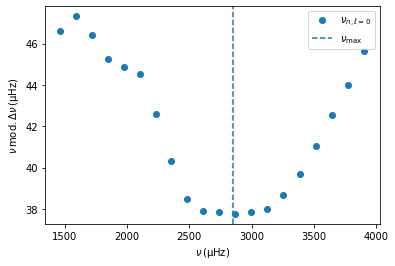

In [9]:
numod = nu % dnu

fig, ax = plt.subplots()

ax.plot(nu, numod, 'o', label=r'$\nu_{n,\ell = 0}$')
ax.axvline(numax, linestyle='--', label=r'$\nu_\mathrm{max}$')
ax.set_ylabel(r'$\nu\,\mathrm{mod.}\Delta\nu\,(\mathrm{\mu Hz})$')
ax.set_xlabel(r'$\nu\,(\mathrm{\mu Hz})$')

ax.legend()

In [10]:
def asy_background(n, epsilon, alpha, delta_nu, nu_max):
    n_max = nu_max / delta_nu - epsilon
    return delta_nu * (n + epsilon + 0.5 * alpha * (n - n_max)**2)

def he_amplitude(nu, b0, b1, lib=tt):
    return b0 * nu * lib.exp(- b1 * nu**2)

def he_glitch(nu, b0, b1, tau_he, phi_he, lib=tt):
    return he_amplitude(nu, b0, b1, lib=lib) * lib.sin(4 * np.pi * tau_he * nu + phi_he)

In [11]:
1/numax

0.00035048457232552424

In [12]:
n = np.arange(10, 30)

epsilon = 1.3
alpha = 0.001
b0 = 10/numax
b1 = 2/numax**2
tau_he = 0.0006
phi_he = np.pi-0.01

delta_nu = dnu
nu_max = numax - 100

glitch = he_glitch(nu, b0, b1, tau_he, phi_he, lib=np)
asy = asy_background(n, epsilon, alpha, delta_nu, nu_max)
model = asy + glitch

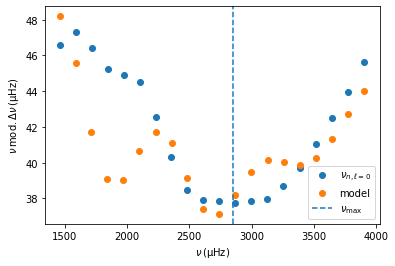

In [13]:
numod = nu % dnu
modelmod = model % dnu

fig, ax = plt.subplots()

ax.plot(nu, numod, 'o', label=r'$\nu_{n,\ell = 0}$')
ax.plot(model, modelmod, 'o', label=r'model')

ax.axvline(numax, linestyle='--', label=r'$\nu_\mathrm{max}$')
ax.set_ylabel(r'$\nu\,\mathrm{mod.}\Delta\nu\,(\mathrm{\mu Hz})$')
ax.set_xlabel(r'$\nu\,(\mathrm{\mu Hz})$')

ax.legend()

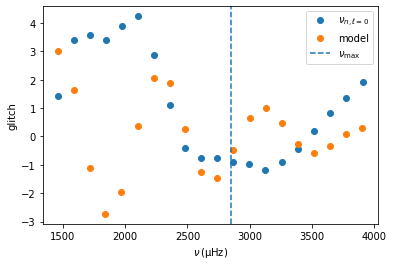

In [14]:
fig, ax = plt.subplots()

ax.plot(nu, nu - asy , 'o', label=r'$\nu_{n,\ell = 0}$')
ax.plot(model, glitch, 'o', label=r'model')

ax.axvline(numax, linestyle='--', label=r'$\nu_\mathrm{max}$')
ax.set_ylabel(r'glitch')
ax.set_xlabel(r'$\nu\,(\mathrm{\mu Hz})$')

ax.legend()

In [15]:
with pm.Model() as model_asy:
    
    epsilon = pm.Normal('epsilon', 1.3, 0.2)
    alpha = pm.Lognormal('alpha', tt.log(0.001), 1.0)
    delta_nu = pm.Normal('delta_nu', dnu, 1.0)
    nu_max = pm.Normal('nu_max', numax, numax*0.05)

    nu_err = pm.HalfNormal('nu_err', 0.1)

    nu_model = pm.Deterministic('nu_model', asy_background(n, epsilon, alpha, delta_nu, nu_max))
    
    nu_obs = pm.Normal('nu_obs', nu_model, nu_err, observed=nu)

In [16]:
from pymc3 import sampling_jax

In [17]:
with model_asy:
    trace_asy = sampling_jax.sample_numpyro_nuts(tune=2000, chains=10, target_accept=0.95)

Compiling...


/Users/ajl573/.virtualenvs/base/lib/python3.8/site-packages/jax/interpreters/xla.py:682: UserWarning: The jitted function _sample includes a pmap. Using jit-of-pmap can lead to inefficient data movement, as the outer jit does not preserve sharded data representations and instead collects input and output arrays onto a single device. Consider removing the outer jit unless you know what you're doing. See https://github.com/google/jax/issues/2926.
  warn(f"The jitted function {fun.__name__} includes a pmap. Using "


Compilation + sampling time =  0 days 00:00:09.640677
Transformation time =  0 days 00:00:00.703562


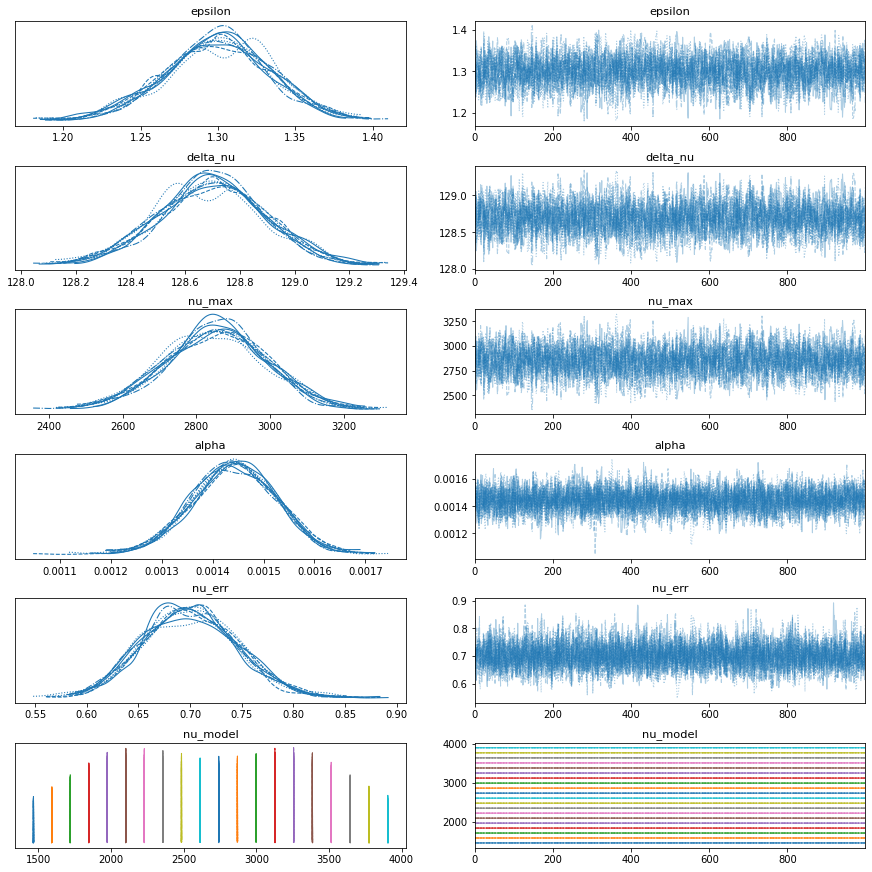

In [18]:
with model_asy:
    ax = az.plot_trace(trace_asy, compact=True)

In [19]:
with model_asy:
    df = az.summary(trace_asy)
df.head()

mean       sd    hdi_3%   hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
epsilon      1.300    0.034     1.232     1.362      0.001    0.000    2707.0   
delta_nu   128.695    0.199   128.321   129.070      0.004    0.003    2706.0   
nu_max    2853.089  136.573  2599.951  3112.821      2.603    1.845    2750.0   
alpha        0.001    0.000     0.001     0.002      0.000    0.000    4819.0   
nu_err       0.701    0.046     0.619     0.787      0.001    0.000    5236.0   

          ess_tail  r_hat  
epsilon     3639.0    1.0  
delta_nu    3675.0    1.0  
nu_max      3900.0    1.0  
alpha       4256.0    1.0  
nu_err      5072.0    1.0

In [20]:
nu_model = trace_asy.posterior['nu_model'].values

In [21]:
nu_model = nu_model.reshape(
        (nu_model.shape[0]*nu_model.shape[1],
         nu_model.shape[2])
    )
nu_model.shape

(10000, 20)

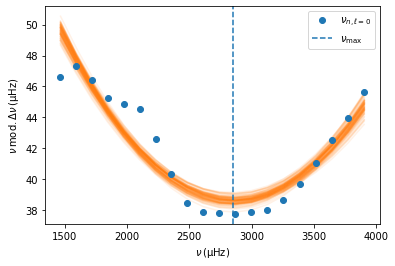

In [22]:
n_samples = 100
samples = np.random.choice(np.arange(nu_model.shape[0]), size=n_samples)

fig, ax = plt.subplots()

ax.plot(nu_model[samples].T, nu_model[samples].T % dnu, '-', color='C1', alpha=0.1)
ax.plot(nu, nu % dnu, 'o', label=r'$\nu_{n,\ell = 0}$')

ax.axvline(numax, linestyle='--', label=r'$\nu_\mathrm{max}$')
ax.set_ylabel(r'$\nu\,\mathrm{mod.}\Delta\nu\,(\mathrm{\mu Hz})$')
ax.set_xlabel(r'$\nu\,(\mathrm{\mu Hz})$')

ax.legend()

In [23]:
with pm.Model() as model_glitch:
    
    epsilon = pm.Normal('epsilon', 1.3, 0.2)
    alpha = pm.Lognormal('alpha', np.log(1e-3), 1.0)
    delta_nu = pm.Normal('delta_nu', dnu, 1.0)
    nu_max = pm.Normal('nu_max', numax, numax*0.05)
    
    b0 = pm.Lognormal('b0', np.log(1/numax), 1.0)
    b1 = pm.Lognormal('b1', np.log(1/numax**2), 1.0)
    
    
#     tau = pm.Lognormal('tau', tt.log(0.001), 0.5)

    # Do it manually like this to prepare for pooling parameters later
    log_tau = pm.Normal('log_tau', 0.0 + -0.99 * np.log(numax), 0.6)
    tau = pm.Deterministic('tau', tt.exp(log_tau))

    phi = pm.VonMises('phi', 0.0, 0.1)

    nu_err = pm.HalfNormal('nu_err', 0.1)
    
    nu_asy = pm.Deterministic('nu_asy', asy_background(n, epsilon, alpha, delta_nu, nu_max))
    nu_glitch = pm.Deterministic('nu_glitch', he_glitch(nu_asy, b0, b1, tau, phi))
    
    nu_model = pm.Deterministic('nu_model', nu_asy + nu_glitch)
    
    nu_obs = pm.Normal('nu_obs', nu_model, nu_err, observed=nu)

In [24]:
with model_glitch:
    trace_glitch = sampling_jax.sample_numpyro_nuts(tune=2000, chains=10, target_accept=0.95)

Compiling...


/Users/ajl573/.virtualenvs/base/lib/python3.8/site-packages/jax/interpreters/xla.py:682: UserWarning: The jitted function _sample includes a pmap. Using jit-of-pmap can lead to inefficient data movement, as the outer jit does not preserve sharded data representations and instead collects input and output arrays onto a single device. Consider removing the outer jit unless you know what you're doing. See https://github.com/google/jax/issues/2926.
  warn(f"The jitted function {fun.__name__} includes a pmap. Using "


Compilation + sampling time =  0 days 00:00:13.817331
Transformation time =  0 days 00:00:19.083021


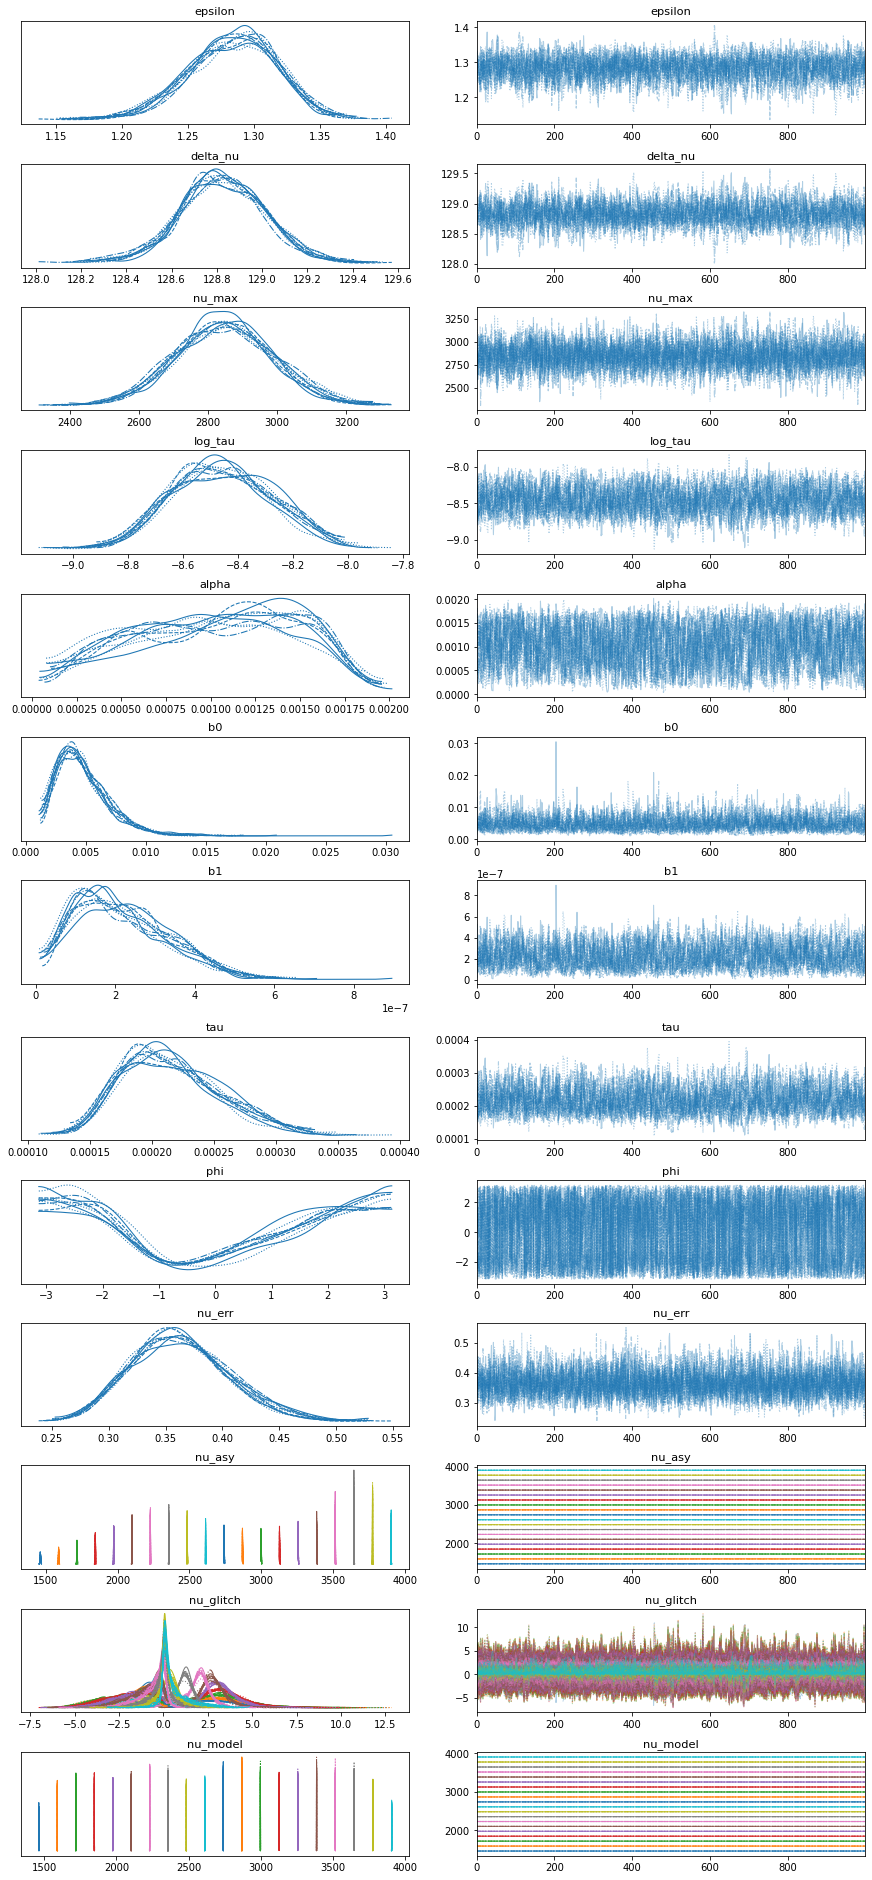

In [25]:
with model_glitch:
    ax = az.plot_trace(trace_glitch, compact=True)

$$\tau \sim \nu_\max^{-0.95}$$

$$\log(\tau) \sim -0.95 * \log(\nu_\max)$$

In [26]:
nu_glitch = trace_glitch.posterior['nu_glitch'].values

In [27]:
nu_glitch = nu_glitch.reshape(
        (nu_glitch.shape[0]*nu_glitch.shape[1],
         nu_glitch.shape[2])
    )
nu_glitch.shape

(10000, 20)

In [28]:
nu_model = trace_glitch.posterior['nu_model'].values

In [29]:
nu_model = nu_model.reshape(
        (nu_model.shape[0]*nu_model.shape[1],
         nu_model.shape[2])
    )
nu_model.shape

(10000, 20)

In [101]:
nu_asy = trace_glitch.posterior['nu_asy'].values

In [107]:
nu_asy = nu_asy.reshape(
        (nu_asy.shape[0]*nu_asy.shape[1],
         nu_asy.shape[2])
    )
nu_asy.shape

(10000, 20)

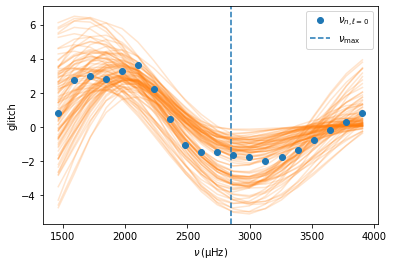

In [108]:
n_samples = 100
samples = np.random.choice(np.arange(nu_model.shape[0]), size=n_samples)

fig, ax = plt.subplots()

ax.plot(nu_model[samples].T, nu_glitch[samples].T, '-', color='C1', alpha=0.2)
ax.plot(nu, nu - nu_asy.mean(axis=0) , 'o', label=r'$\nu_{n,\ell = 0}$')

ax.axvline(numax, linestyle='--', label=r'$\nu_\mathrm{max}$')
ax.set_ylabel(r'glitch')
ax.set_xlabel(r'$\nu\,(\mathrm{\mu Hz})$')

ax.legend()

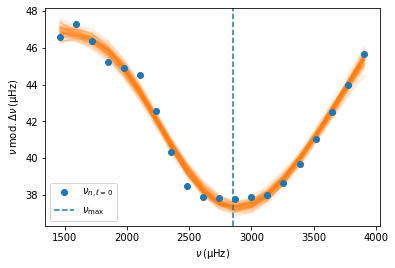

In [31]:
fig, ax = plt.subplots()

ax.plot(nu_model[samples].T, nu_model[samples].T % dnu, '-', color='C1', alpha=0.1)
ax.plot(nu, nu % dnu, 'o', label=r'$\nu_{n,\ell = 0}$')

ax.axvline(numax, linestyle='--', label=r'$\nu_\mathrm{max}$')
ax.set_ylabel(r'$\nu\,\mathrm{mod.}\Delta\nu\,(\mathrm{\mu Hz})$')
ax.set_xlabel(r'$\nu\,(\mathrm{\mu Hz})$')

ax.legend()

## Model He + BCZ glitch

In [32]:
def cz_amplitude(nu, c0):
    return c0 / nu**2

def cz_glitch(nu, c0, tau, phi):
    return cz_amplitude(nu, c0) * tt.sin(4 * np.pi * tau * nu + phi)

In [56]:
def glitch(nu, tau, phi):
    return tt.sin(4 * np.pi * tau * nu + phi)

In [81]:
with pm.Model() as model_glitch_hecz:
    
    # Asymptotic background
    epsilon = pm.Normal('epsilon', 1.3, 0.2)
    alpha = pm.Lognormal('alpha', np.log(1e-3), 1.0)
    delta_nu = pm.Normal('delta_nu', dnu, 1.0)
    nu_max = pm.Normal('nu_max', numax, numax*0.05)
    
    # He glitch
    b0 = pm.Lognormal('b0', np.log(1/numax), 1.0)
    b1 = pm.Lognormal('b1', np.log(1/numax**2), 1.0)
    tau_he = pm.Lognormal('tau_he', np.log(0.0005), 0.8)
    phi_he = pm.VonMises('phi_he', 0.0, 0.1)
    
    
    # BCZ glitch
    c0 = pm.Lognormal('c0', np.log(numax**2), 1.0)
    tau_cz = pm.Lognormal('tau_cz', tt.log(0.001), 0.8)
    phi_cz = pm.VonMises('phi_cz', 0.0, 0.1)
    
    delta_tau_logp = pm.Lognormal.dist(np.log(0.001), 0.8).logp(tau_cz - tau_he)
    delta_tau = pm.Potential('delta_tau', delta_tau_logp)
    
    nu_err = pm.HalfNormal('nu_err', 0.1)
    
    nu_asy = pm.Deterministic('nu_asy', asy_background(n, epsilon, alpha, delta_nu, nu_max))

    amp_he = pm.Deterministic('amp_he', he_amplitude(nu_asy, b0, b1))
    amp_cz = pm.Deterministic('amp_cz', cz_amplitude(nu_asy, c0))
    
#     delta_amp_logp = pm.Lognormal.dist(np.log(0.1), 0.5).logp(amp_cz/amp_he)
#     delta_amp = pm.Potential('delta_amp', delta_amp_logp)
    
#     dnu_he = pm.Deterministic('dnu_he', he_glitch(nu_asy, b0, b1, tau_he, phi_he))
#     dnu_cz = pm.Deterministic('dnu_cz', cz_glitch(nu_asy, c0, tau_cz, phi_cz))
    
    dnu_he = pm.Deterministic('dnu_he', amp_he * glitch(nu_asy, tau_he, phi_he))
    dnu_cz = pm.Deterministic('dnu_cz', amp_cz * glitch(nu_asy, tau_cz, phi_cz))

    nu_model = pm.Deterministic('nu_model', nu_asy + dnu_he + dnu_cz)
    
    nu_obs = pm.Normal('nu_obs', nu_model, nu_err, observed=nu)

In [82]:
with model_glitch_hecz:
    trace_glitch_hecz = sampling_jax.sample_numpyro_nuts(tune=2000, chains=10, target_accept=0.95)

Compiling...


/Users/ajl573/.virtualenvs/base/lib/python3.8/site-packages/jax/interpreters/xla.py:682: UserWarning: The jitted function _sample includes a pmap. Using jit-of-pmap can lead to inefficient data movement, as the outer jit does not preserve sharded data representations and instead collects input and output arrays onto a single device. Consider removing the outer jit unless you know what you're doing. See https://github.com/google/jax/issues/2926.
  warn(f"The jitted function {fun.__name__} includes a pmap. Using "


Compilation + sampling time =  0 days 00:00:19.981393
Transformation time =  0 days 00:02:55.003689


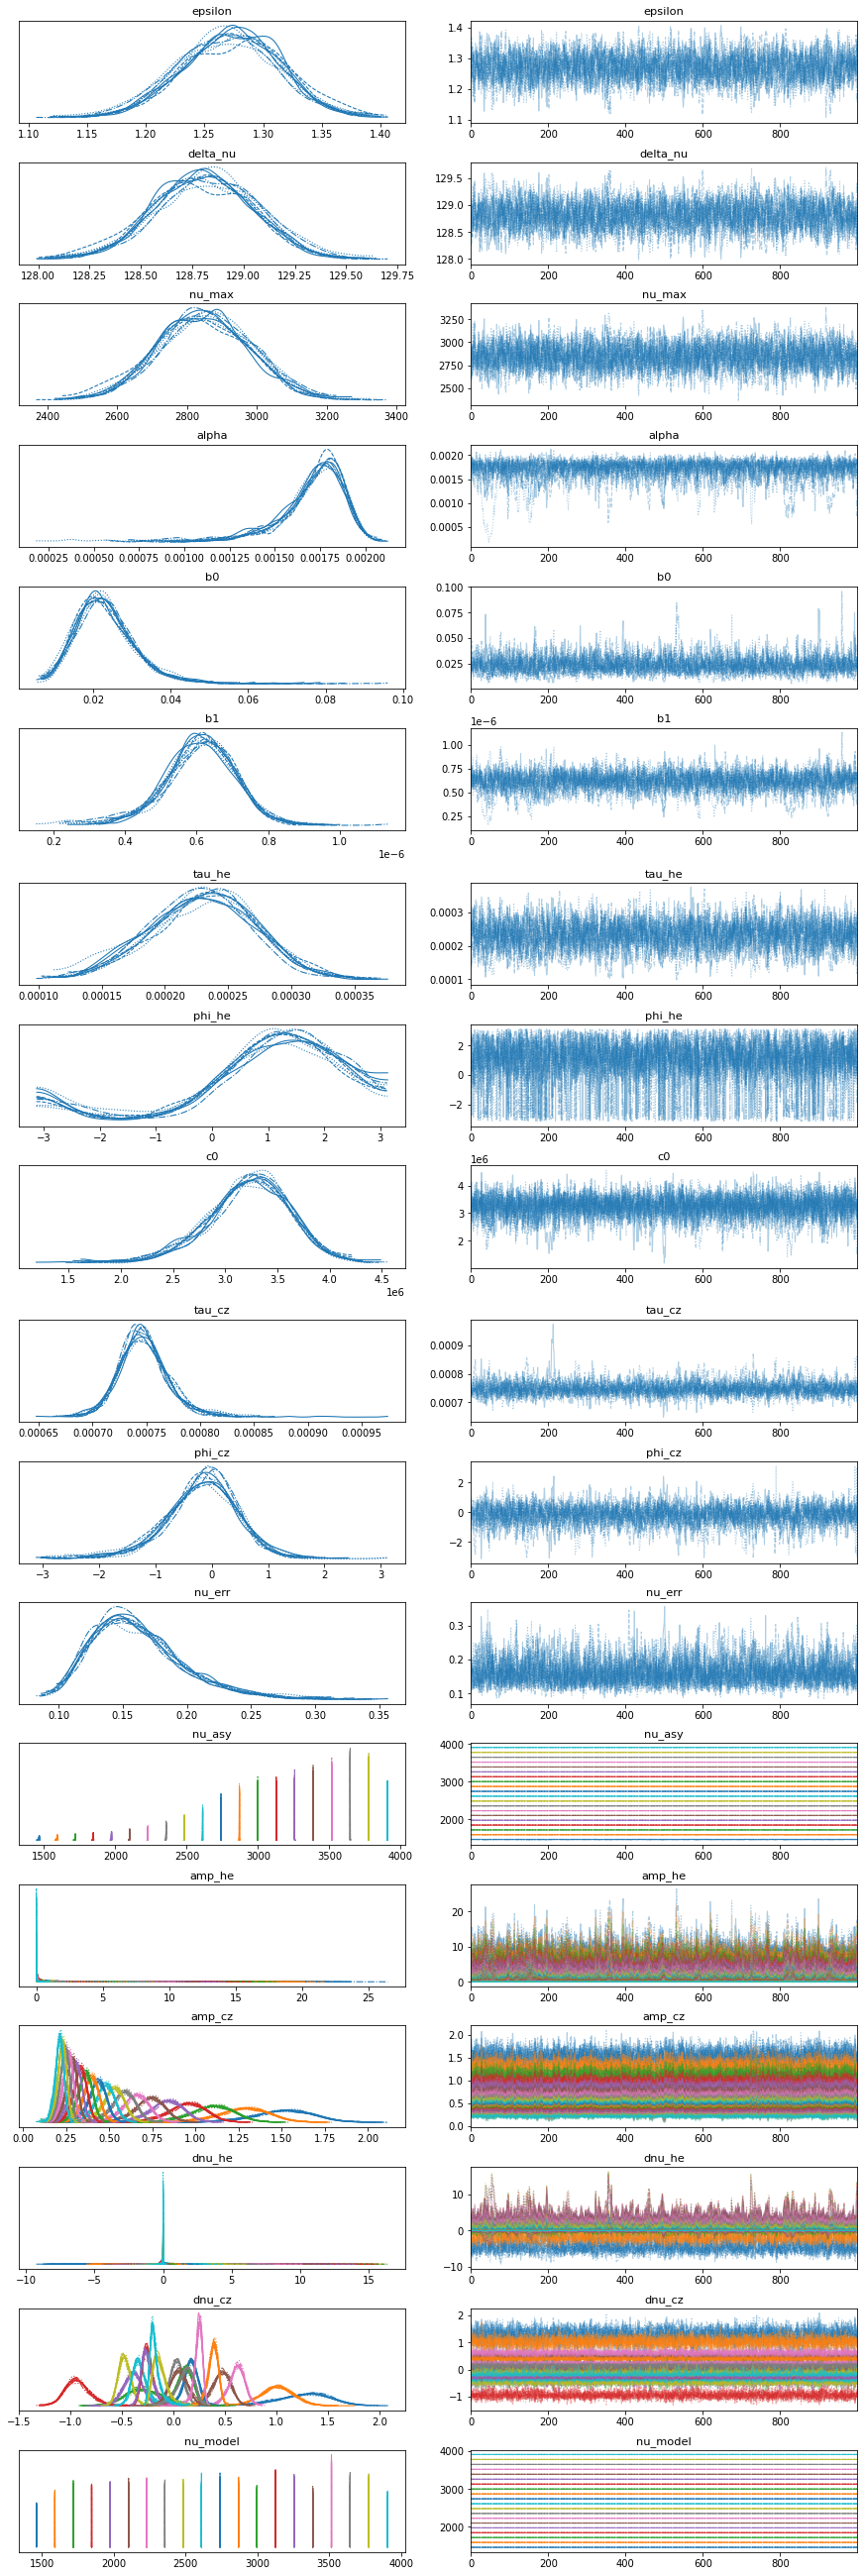

In [83]:
with model_glitch_hecz:
    ax = az.plot_trace(trace_glitch_hecz, compact=True)

$$\tau \sim \nu_\max^{-0.95}$$

$$\log(\tau) \sim -0.95 * \log(\nu_\max)$$

In [94]:
dnu_he = trace_glitch_hecz.posterior['dnu_he'].values
dnu_cz = trace_glitch_hecz.posterior['dnu_cz'].values
nu_glitch_hecz = dnu_he + dnu_cz

In [95]:
nu_glitch_hecz = nu_glitch_hecz.reshape(
        (nu_glitch_hecz.shape[0]*nu_glitch_hecz.shape[1],
         nu_glitch_hecz.shape[2])
    )
nu_glitch_hecz.shape

(10000, 20)

In [96]:
nu_model_hecz = trace_glitch_hecz.posterior['nu_model'].values

In [97]:
nu_model_hecz = nu_model_hecz.reshape(
        (nu_model_hecz.shape[0]*nu_model_hecz.shape[1],
         nu_model_hecz.shape[2])
    )
nu_model_hecz.shape

(10000, 20)

In [114]:
nu_asy_hecz = trace_glitch_hecz.posterior['nu_asy'].values

In [115]:
nu_asy_hecz = nu_asy_hecz.reshape(
        (nu_asy_hecz.shape[0]*nu_asy_hecz.shape[1],
         nu_asy_hecz.shape[2])
    )
nu_asy_hecz.shape

(10000, 20)

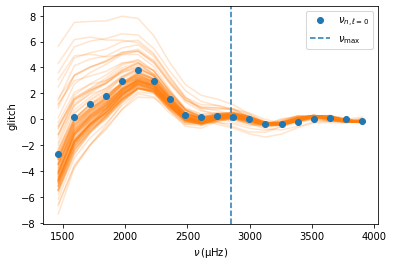

In [116]:
n_samples = 100
samples = np.random.choice(np.arange(nu_model_hecz.shape[0]), size=n_samples)

fig, ax = plt.subplots()

ax.plot(nu_model_hecz[samples].T, nu_glitch_hecz[samples].T, '-', color='C1', alpha=0.2)
ax.plot(nu, nu - nu_asy_hecz.mean(axis=0), 'o', label=r'$\nu_{n,\ell = 0}$')

ax.axvline(numax, linestyle='--', label=r'$\nu_\mathrm{max}$')
ax.set_ylabel(r'glitch')
ax.set_xlabel(r'$\nu\,(\mathrm{\mu Hz})$')

ax.legend()

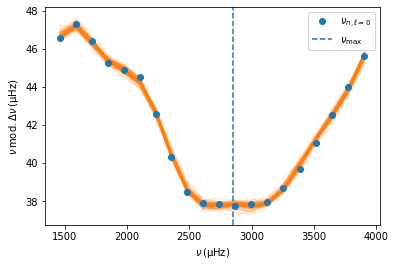

In [99]:
fig, ax = plt.subplots()

ax.plot(nu_model_hecz[samples].T, nu_model_hecz[samples].T % dnu, '-', color='C1', alpha=0.1)
ax.plot(nu, nu % dnu, 'o', label=r'$\nu_{n,\ell = 0}$')

ax.axvline(numax, linestyle='--', label=r'$\nu_\mathrm{max}$')
ax.set_ylabel(r'$\nu\,\mathrm{mod.}\Delta\nu\,(\mathrm{\mu Hz})$')
ax.set_xlabel(r'$\nu\,(\mathrm{\mu Hz})$')

ax.legend()

## Model many

In [112]:
# profile = track.loc[track['frac_age'] < 0.5].iloc[-1]
n_stars = 10
profiles = track.loc[(track['frac_age'] > 0.01) & (track['frac_age'] < 0.8)].sample(n_stars)
profiles

frac_age  delta_nu_fit       nu_max  nu_0_1  nu_0_2      nu_0_3  \
456  0.103536    151.368185  3570.075842     0.0     0.0  587.484062   
688  0.731421    114.800787  2442.267004     0.0     0.0  466.712108   
690  0.735967    114.497013  2433.536193     0.0     0.0  465.653604   
574  0.443804    132.834340  2979.789656     0.0     0.0  527.112888   
529  0.318379    139.967635  3202.493763     0.0     0.0  550.299164   
562  0.410950    134.740529  3038.840675     0.0     0.0  533.332171   
635  0.603448    123.129438  2685.981095     0.0     0.0  495.106058   
526  0.309812    140.438916  3217.399238     0.0     0.0  551.826236   
564  0.416457    134.422714  3028.974403     0.0     0.0  532.296727   
532  0.326921    139.495070  3187.582943     0.0     0.0  548.768081   

         nu_0_4      nu_0_5       nu_0_6       nu_0_7  ...      nu_0_32  \
456  749.044300  914.157888  1078.352780  1241.055898  ...  5063.251651   
688  582.724325  702.073272   823.320248   944.252923  ...  3825.260287   
690  581.354942  700.336667   821.237939   941.824190  ...  3815.042043   
574  663.961048  805.781134   947.953662  1089.599990  ...  4436.075108   
529  696.439689  847.265354   997.871732  1147.675514  ...  4677.092340   
562  672.623600  816.855262   961.279176  1105.112513  ...  4500.547000   
635  620.181269  749.803215   880.615117  1011.111313  ...  4107.958235   
526  698.593109  850.012101  1001.177747  1151.518554  ...  4693.021534   
564  671.178542  815.008347   959.056780  1102.526008  ...  4489.803563   
532  694.282401  844.512490   994.558975  1143.824496  ...  4661.128133   

         nu_0_33      nu_0_34      nu_0_35      nu_0_36      nu_0_37  \
456  5216.375416  5369.032143  5520.864314  5668.045196  5817.861385   
688  3938.456141  4049.844618  4158.461221  4264.047554  4368.268492   
690  3927.883720  4038.889372  4147.099871  4252.306297  4356.238106   
574  4569.009368  4698.503853  4829.698254  4959.076696  5085.586540   
529  4818.142586  4957.948723  5094.207850  5232.274758  5368.161314   
562  4635.747900  4767.101085  4900.522974  5032.265378  5161.345981   
635  4228.237105  4349.703433  4469.124685  4585.781654  4699.376478   
526  4834.578824  4974.984532  5111.663203  5250.283270  5386.771883   
564  4624.633677  4755.668817  4888.723798  5020.073990  5148.729373   
532  4801.664744  4940.851467  5076.708676  5214.215591  5349.499220   

         nu_0_38      nu_0_39      nu_0_40  surface_he4  
456  5965.854840  6111.009106  6253.133543     0.234231  
688  4473.841346  4582.570364  4693.951714     0.202205  
690  4461.630770  4570.186376  4681.372499     0.201966  
574  5209.035454  5330.273809  5452.315472     0.216851  
529  5501.194550  5631.143685  5759.054368     0.223251  
562  5287.296328  5410.674188  5534.081412     0.218528  
635  4811.345740  4924.814452  5041.139020     0.208722  
526  5520.446153  5651.012792  5779.402184     0.223696  
564  5274.258559  5397.266998  5520.438371     0.218248  
532  5481.883456  5611.216475  5738.659297     0.222816  

[10 rows x 44 columns]

In [113]:
nus = profiles[nu_index].to_numpy().astype(float).T

In [114]:
nus.shape

(20, 10)

In [115]:
ns = n[:, np.newaxis]
ns.shape

(20, 1)

In [121]:
numaxs = profiles['nu_max'].to_numpy()
dnus = profiles['delta_nu_fit'].to_numpy()

In [122]:
with pm.Model() as model_asy_many:
    
    epsilon = pm.Normal('epsilon', 1.3, 0.2, shape=n_stars)
    alpha = pm.Lognormal('alpha', np.log(0.001), 1.0, shape=n_stars)
    delta_nu = pm.Normal('delta_nu', dnus, 1.0, shape=n_stars)
    nu_max = pm.Normal('nu_max', numaxs, numaxs*0.05, shape=n_stars)

    nu_err = pm.HalfNormal('nu_err', 0.1, shape=n_stars)

    nu_model = pm.Deterministic('nu_model', asy_background(ns, epsilon, alpha, delta_nu, nu_max))
    
    nu_obs = pm.Normal('nu_obs', nu_model, nu_err, observed=nus)

In [123]:
with model_asy_many:
    trace_asy_many = sampling_jax.sample_numpyro_nuts(tune=2000, chains=10, target_accept=0.95)

Compiling...


/Users/ajl573/.virtualenvs/base/lib/python3.8/site-packages/jax/interpreters/xla.py:682: UserWarning: The jitted function _sample includes a pmap. Using jit-of-pmap can lead to inefficient data movement, as the outer jit does not preserve sharded data representations and instead collects input and output arrays onto a single device. Consider removing the outer jit unless you know what you're doing. See https://github.com/google/jax/issues/2926.
  warn(f"The jitted function {fun.__name__} includes a pmap. Using "


Compilation + sampling time =  0 days 00:00:12.130591
Transformation time =  0 days 00:00:00.068108


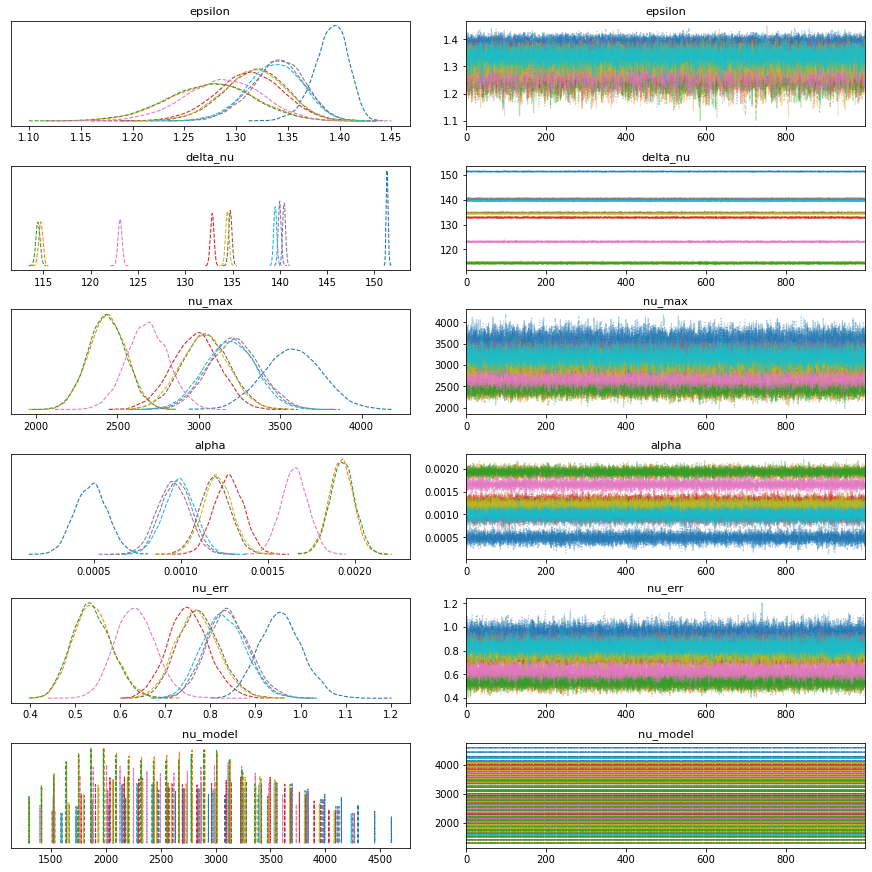

In [124]:
with model_asy_many:
    ax = az.plot_trace(trace_asy_many, compact=True, combined=True)

Use these as initial values?

In [125]:
with pm.Model() as model_glitch_many:
    
    epsilon = pm.Normal('epsilon', 1.3, 0.2, shape=n_stars)
    alpha = pm.Lognormal('alpha', np.log(1e-3), 1.0, shape=n_stars)
    delta_nu = pm.Normal('delta_nu', dnus, 1.0, shape=n_stars)
    nu_max = pm.Normal('nu_max', numaxs, numaxs*0.05, shape=n_stars)
    
    b0 = pm.Lognormal('b0', np.log(1/numaxs), 1.0, shape=n_stars)
    b1 = pm.Lognormal('b1', np.log(1/numaxs**2), 1.0, shape=n_stars)
    tau = pm.Lognormal('tau', np.log(0.0005), 0.5, shape=n_stars)

#     log_tau = pm.Normal('log_tau', 0.0 + -0.99 * np.log(numax), 0.6)
#     tau = pm.Deterministic('tau', tt.exp(log_tau))
    
    phi = pm.VonMises('phi', 0.0, 0.1, shape=n_stars)

    nu_err = pm.HalfNormal('nu_err', 0.1, shape=n_stars)
    
    nu_asy = pm.Deterministic('nu_asy', asy_background(ns, epsilon, alpha, delta_nu, nu_max))
    nu_glitch = pm.Deterministic('nu_glitch', he_glitch(nu_asy, b0, b1, tau, phi))
    
    nu_model = pm.Deterministic('nu_model', nu_asy + nu_glitch)

    nu_obs = pm.Normal('nu_obs', nu_model, nu_err, observed=nus)

In [126]:
with model_glitch_many:
    trace_glitch_many = sampling_jax.sample_numpyro_nuts(tune=2000, chains=10, target_accept=0.95)

Compiling...


/Users/ajl573/.virtualenvs/base/lib/python3.8/site-packages/jax/interpreters/xla.py:682: UserWarning: The jitted function _sample includes a pmap. Using jit-of-pmap can lead to inefficient data movement, as the outer jit does not preserve sharded data representations and instead collects input and output arrays onto a single device. Consider removing the outer jit unless you know what you're doing. See https://github.com/google/jax/issues/2926.
  warn(f"The jitted function {fun.__name__} includes a pmap. Using "


Compilation + sampling time =  0 days 00:00:18.414642
Transformation time =  0 days 00:09:55.305318


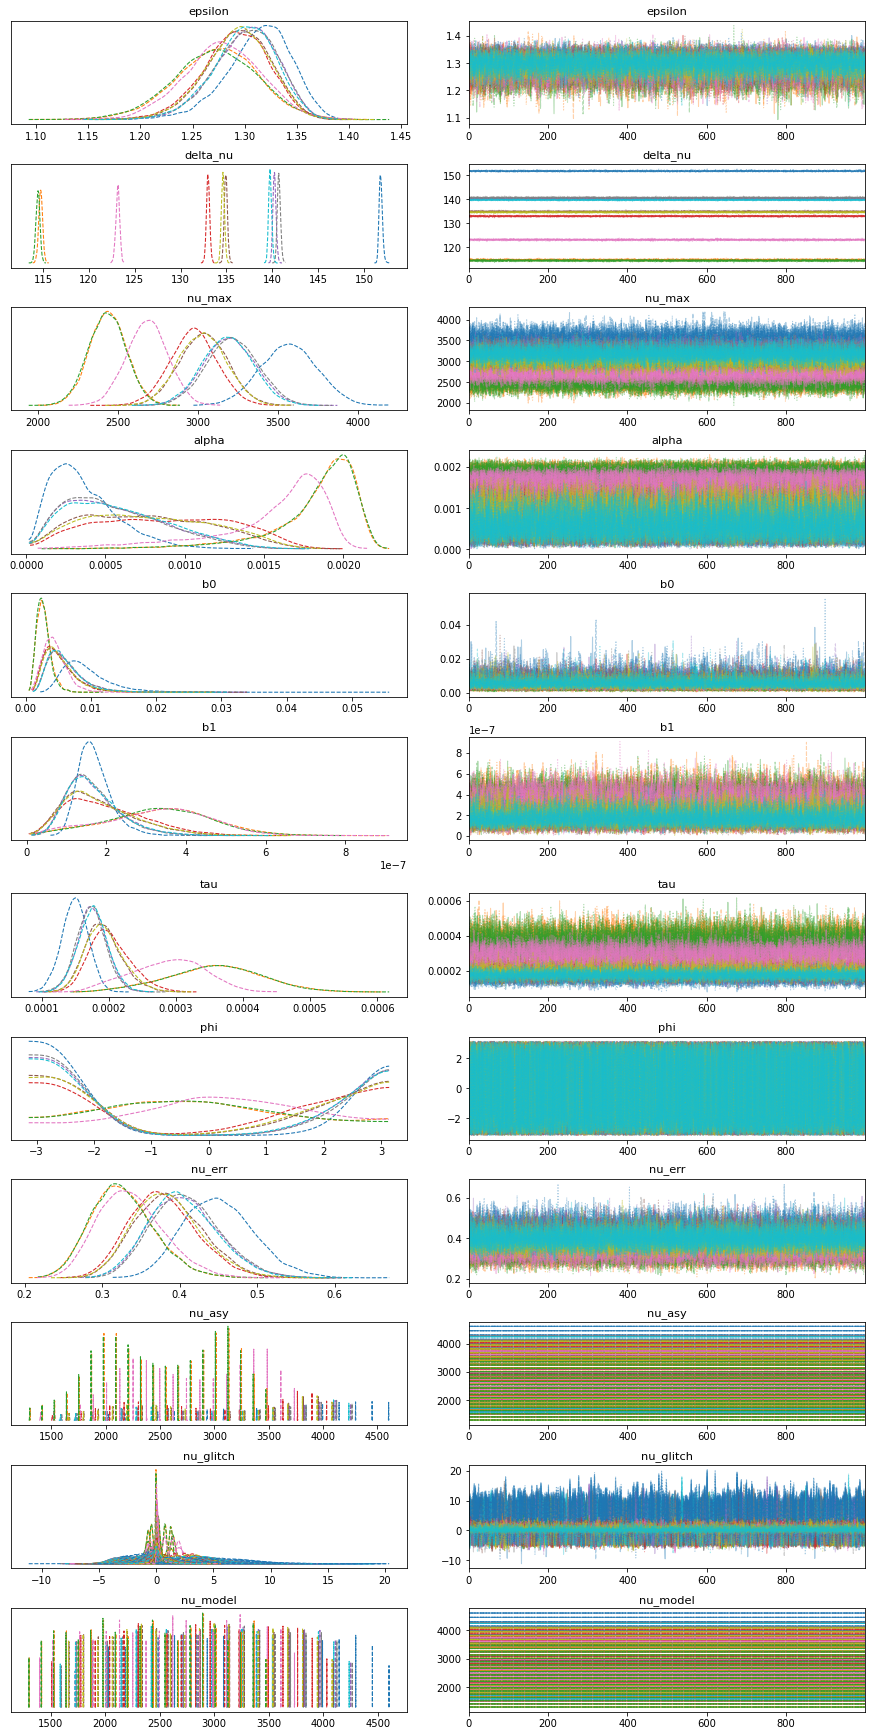

In [127]:
with model_glitch_many:
    ax = az.plot_trace(trace_glitch_many, compact=True, combined=True)

Now we pool tau using a relation tested earlier

In [138]:
with pm.Model() as model_glitch_pooled:
    
    c = pm.Normal('c', 0.0, 0.1)
    m = pm.Normal('m', 1.0, 0.05)
    
    epsilon = pm.Normal('epsilon', 1.3, 0.2, shape=n_stars)
    alpha = pm.Lognormal('alpha', np.log(1e-3), 1.0, shape=n_stars)
    delta_nu = pm.Normal('delta_nu', dnus, 1.0, shape=n_stars)
    nu_max = pm.Normal('nu_max', numaxs, numaxs*0.05, shape=n_stars)
    
    b0 = pm.Lognormal('b0', np.log(1/numaxs), 1.0, shape=n_stars)
    b1 = pm.Lognormal('b1', np.log(1/numaxs**2), 1.0, shape=n_stars)
#     tau = pm.Deterministic('tau', d * nu_max**(-m))

    log_tau = pm.Normal('log_tau', c - m * tt.log(nu_max), 0.6, shape=n_stars)
    tau = pm.Deterministic('tau', tt.exp(log_tau))

    phi = pm.VonMises('phi', 0.0, 0.1, shape=n_stars)

    nu_err = pm.HalfNormal('nu_err', 0.1, shape=n_stars)
    
    nu_asy = pm.Deterministic('nu_asy', asy_background(ns, epsilon, alpha, delta_nu, nu_max))
    nu_glitch = pm.Deterministic('nu_glitch', he_glitch(nu_asy, b0, b1, tau, phi))
    
    nu_model = pm.Deterministic('nu_model', nu_asy + nu_glitch)

    nu_obs = pm.Normal('nu_obs', nu_model, nu_err, observed=nus)

In [139]:
with model_glitch_pooled:
    trace_glitch_pooled = sampling_jax.sample_numpyro_nuts(tune=2000, chains=4, target_accept=0.95)

Compiling...


/Users/ajl573/.virtualenvs/base/lib/python3.8/site-packages/jax/interpreters/xla.py:682: UserWarning: The jitted function _sample includes a pmap. Using jit-of-pmap can lead to inefficient data movement, as the outer jit does not preserve sharded data representations and instead collects input and output arrays onto a single device. Consider removing the outer jit unless you know what you're doing. See https://github.com/google/jax/issues/2926.
  warn(f"The jitted function {fun.__name__} includes a pmap. Using "


Compilation + sampling time =  0 days 00:00:21.797877
Transformation time =  0 days 00:04:55.438378


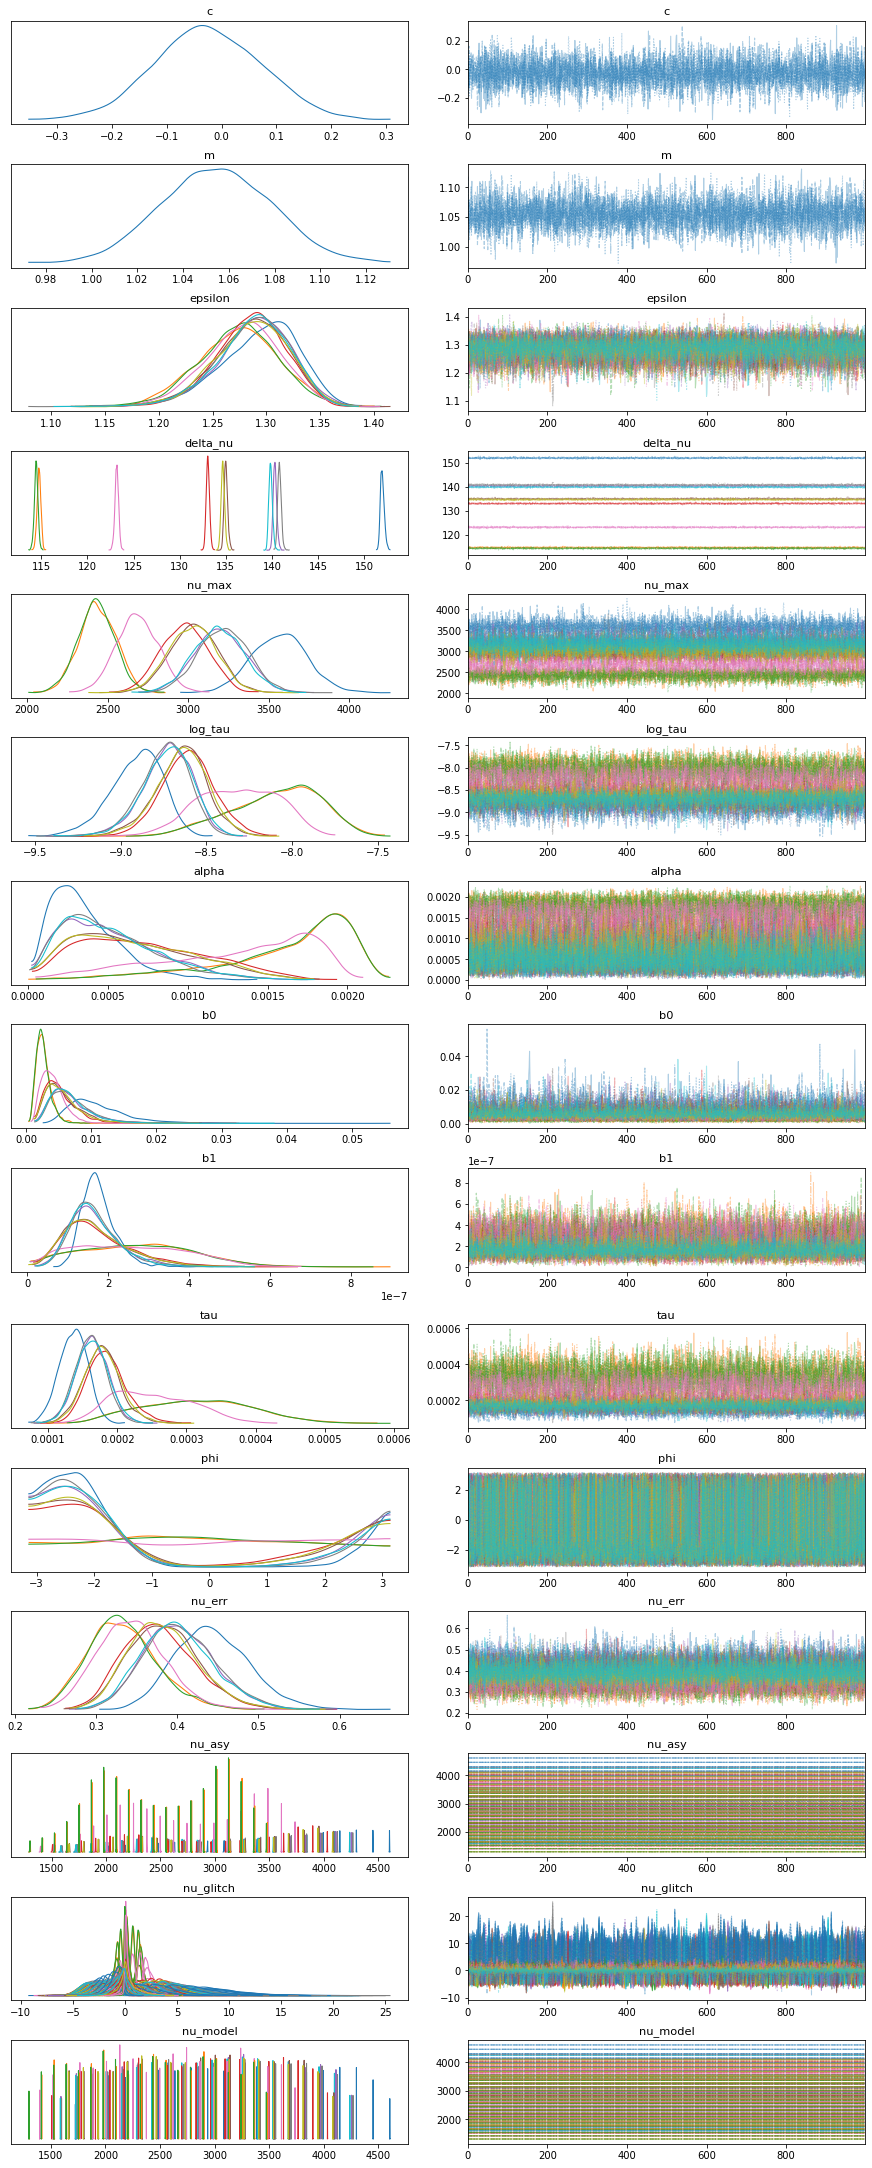

In [140]:
with model_glitch_pooled:
    ax = az.plot_trace(trace_glitch_pooled, compact=True, combined=True)